# BAF660 빅데이터와 금융자료분석 - 기말대체과제 Q2 (`prob2_card.csv`)

이 스크립트는 `prob2_card.csv` 데이터셋을 이용하여 클러스터링 분석을 수행합니다.
EDA(`final_eda_2.py`) 결과를 바탕으로 진행됩니다.

## 0. 라이브러리 임포트 및 기본 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from math import pi
import os
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

# 시각화 설정
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# 플롯 저장 디렉토리 생성
plot_dir_q2 = 'plots/q2'
os.makedirs(plot_dir_q2, exist_ok=True)

## 1. 데이터 로드 및 확인

In [2]:
# 데이터 로드
card_data_q2 = pd.read_csv('prob2_card.csv')

print("--- Credit Card 데이터셋 (Q2) ---")
print("데이터셋 형태:", card_data_q2.shape)

# CUST_ID를 인덱스로 설정
if 'CUST_ID' in card_data_q2.columns:
    if card_data_q2['CUST_ID'].nunique() == len(card_data_q2):
        print("\nCUST_ID를 인덱스로 설정합니다.")
        card_data_q2.set_index('CUST_ID', inplace=True)
    else:
        print("\n경고: CUST_ID가 고유하지 않아 인덱스로 설정하지 않습니다.")
else:
    print("\n경고: CUST_ID 컬럼이 없습니다.")

# 결측치 확인 (EDA에서 확인 완료, 없었음)
# print("\n결측치 확인:")
# print(card_data_q2.isnull().sum())

print("\n데이터 상위 5개 행:")
print(card_data_q2.head())

--- Credit Card 데이터셋 (Q2) ---
데이터셋 형태: (8950, 6)

CUST_ID를 인덱스로 설정합니다.

데이터 상위 5개 행:
             BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
CUST_ID                                                                   
C10001     40.900749           0.818182      95.40             0.166667   
C10002   3202.467416           0.909091       0.00             0.000000   
C10003   2495.148862           1.000000     773.17             1.000000   
C10004   1666.670542           0.636364    1499.00             0.083333   
C10005    817.714335           1.000000      16.00             0.083333   

         PURCHASES_TRX  
CUST_ID                 
C10001               2  
C10002               0  
C10003              12  
C10004               1  
C10005               1  


## 2. K-Means 클러스터링

### 2.1 원본 데이터 분포 확인


--- 원본 데이터 분포 확인 중... ---


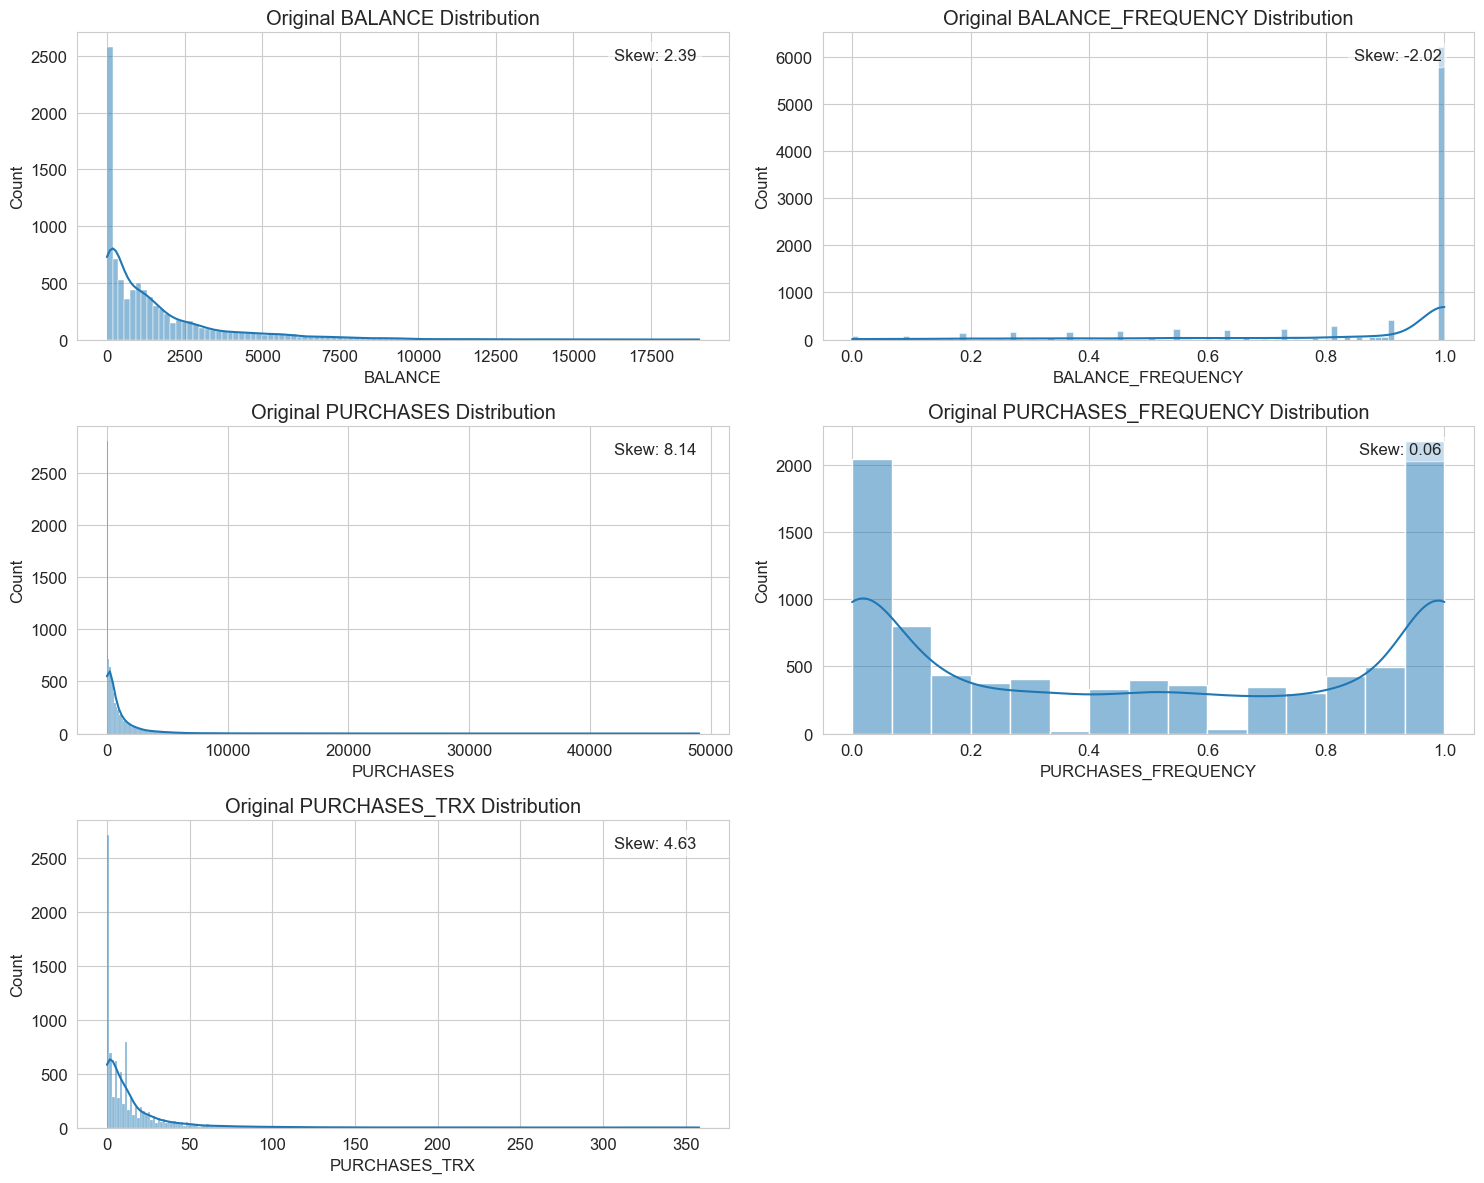

In [3]:
# 원본 데이터 분포 시각화 (EDA 결과 참고, 여기서는 간단히 재확인)
card_numerical_cols = card_data_q2.columns.tolist()
num_plots = len(card_numerical_cols)
num_cols_grid = 2
num_rows_grid = (num_plots + num_cols_grid - 1) // num_cols_grid

fig_hist_orig, axes_hist_orig = plt.subplots(num_rows_grid, num_cols_grid, figsize=(15, num_rows_grid * 4))
axes_hist_orig = axes_hist_orig.flatten()

print("\n--- 원본 데이터 분포 확인 중... ---")
for i, col in enumerate(card_numerical_cols):
    sns.histplot(card_data_q2[col], kde=True, ax=axes_hist_orig[i])
    axes_hist_orig[i].set_title(f'Original {col} Distribution')
    skewness = card_data_q2[col].skew()
    axes_hist_orig[i].text(0.95, 0.95, f'Skew: {skewness:.2f}', 
                           transform=axes_hist_orig[i].transAxes, ha='right', va='top',
                           bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
    
for j in range(i + 1, len(axes_hist_orig)):
    fig_hist_orig.delaxes(axes_hist_orig[j])
    
plt.tight_layout()
plot_filename_hist_orig = os.path.join(plot_dir_q2, 'original_distributions.png')
plt.savefig(plot_filename_hist_orig)
plt.show()
plt.close(fig_hist_orig)

### 2.2 전처리 필요성 설명

- 위 분포에서 확인되듯, `BALANCE`, `PURCHASES`, `PURCHASES_TRX` 등 대부분의 변수가 오른쪽으로 매우 치우친(highly skewed) 분포를 보입니다.
- K-Means 클러스터링은 유클리드 거리(L2 distance)를 기반으로 하므로, 변수의 **스케일**과 **이상치(outlier)**에 매우 민감합니다.
- 스케일이 큰 변수가 결과에 과도한 영향을 미치거나, 이상치가 군집 중심을 왜곡시킬 수 있습니다.
- 따라서 효과적인 K-Means 클러스터링을 위해 **이상치 처리**와 **데이터 스케일링/변환**이 필요합니다.

### 2.3 원본 데이터 이상치 탐색
- 클러스터링 적용 전에 원본 데이터의 이상치를 다양한 방법으로 탐색합니다.

#### 2.3.1 IQR 방법

In [ ]:
# IQR(사분위 범위) 방법으로 이상치 탐지 함수 정의
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 각 수치형 변수에 대해 IQR 이상치 탐지 (시각화 생략)
print("\n--- 원본 데이터 IQR 이상치 탐색 중 (요약만 출력)... ---")
card_outlier_stats_orig = {}
for i, col in enumerate(card_numerical_cols):
    outliers, lower_bound, upper_bound = detect_outliers_iqr(card_data_q2, col)
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(card_data_q2)) * 100
    
    card_outlier_stats_orig[col] = {
        'outlier_count': outlier_count,
        'outlier_percent': outlier_percent
        # 'lower_bound': lower_bound, # 요약에는 불필요
        # 'upper_bound': upper_bound
    }
    
    # # 시각화 코드 제거됨
    # fig = plt.figure(figsize=(15, 5))
    # plt.scatter(card_data_q2.index, card_data_q2[col], alpha=0.5)
    # plt.axhline(y=lower_bound, color='r', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')
    # plt.axhline(y=upper_bound, color='r', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
    # plt.title(f'Original {col} Outliers (IQR Method) - {outlier_count} ({outlier_percent:.2f}%)')
    # plt.ylabel(col)
    # plt.legend()
    # plot_filename = os.path.join(plot_dir_q2, f'outlier_iqr_original_{col}.png')
    # plt.savefig(plot_filename)
    # plt.show()
    # plt.close(fig)

card_outlier_summary_orig = pd.DataFrame.from_dict(card_outlier_stats_orig, orient='index')
print("\nIQR 방법 이상치 요약 (원본 데이터):")
print(card_outlier_summary_orig)

#### 2.3.2 Isolation Forest
- Isolation Forest는 이상치가 정상 데이터보다 더 쉽게 **고립(isolate)**될 수 있다는 원리를 이용한 트리 기반 앙상블 방법입니다.
- `contamination` 파라미터를 지정하지 않아 Scikit-learn의 기본 동작(내부 점수 임계값 사용)을 따르도록 합니다.

In [ ]:
# IsolationForest 이상치 탐지 함수 정의
def detect_outliers_iforest(df, cols):
    X = df[cols].copy()
    # contamination 파라미터 생략 (기본 동작 사용)
    clf = IsolationForest(random_state=42)
    y_pred = clf.fit_predict(X)
    return y_pred == -1 # 아웃라이어 여부 마스크 반환

print("\n--- 원본 데이터 Isolation Forest 이상치 탐색 중... ---")
# contamination_rate = 0.05 # 제거
card_is_outlier_if_orig = detect_outliers_iforest(card_data_q2, card_numerical_cols)

card_outlier_count_if_orig = np.sum(card_is_outlier_if_orig)
card_outlier_percent_if_orig = (card_outlier_count_if_orig / len(card_data_q2)) * 100
print(f"IsolationForest로 탐지한 이상치 (원본 데이터, contamination=default): {card_outlier_count_if_orig}개 ({card_outlier_percent_if_orig:.2f}%)")

# 시각화를 위해 PCA로 차원 축소 (원본 데이터 기준)
pca_orig = PCA(n_components=2)
card_X_pca_orig = pca_orig.fit_transform(card_data_q2)

# 이상치 시각화 (2D PCA)
fig_if_orig = plt.figure(figsize=(10, 8))
plt.scatter(card_X_pca_orig[~card_is_outlier_if_orig, 0], card_X_pca_orig[~card_is_outlier_if_orig, 1], c='blue', s=5, label='Normal Data')
plt.scatter(card_X_pca_orig[card_is_outlier_if_orig, 0], card_X_pca_orig[card_is_outlier_if_orig, 1], c='red', s=20, label='Outliers')
plt.title('Outliers Detection by IsolationForest (Original Data - PCA 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plot_filename_if_orig = os.path.join(plot_dir_q2, 'outlier_iforest_pca_original.png')
plt.savefig(plot_filename_if_orig)
plt.show()
plt.close(fig_if_orig)

#### 2.3.3 LOF (Local Outlier Factor)
- LOF는 주변 데이터 포인트와의 **밀도(density)**를 비교하여 이상치를 탐지합니다.
- 주변보다 밀도가 현저히 낮은 포인트를 이상치로 간주합니다.
- 거리 기반 방법이므로, 분포 왜곡을 줄이는 Power Transformation을 적용한 데이터에 LOF를 적용하여 탐색합니다.

In [ ]:
# LOF 이상치 탐지 함수 정의 (내부에서 Power Transform 적용)
def detect_outliers_lof_powertransformed(df, cols, contamination=0.05):
    X = df[cols].copy()
    
    # Power Transformation 적용
    pt = PowerTransformer(method='yeo-johnson')
    try:
        X_transformed = pt.fit_transform(X)
    except ValueError:
        print("경고: LOF 내부 PowerTransform 중 오류 발생. 스케일링 없이 진행합니다.")
        X_transformed = X # 오류 시 원본 사용 (대안 필요할 수 있음)

    clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    y_pred = clf.fit_predict(X_transformed) # 변환된 데이터 사용
    return y_pred == -1

print("\n--- 원본 데이터 LOF 이상치 탐색 중... (PowerTransform 적용 후) ---")
contamination_rate_lof = 0.05 # LOF 오염도 설정
card_is_outlier_lof_orig = detect_outliers_lof_powertransformed(card_data_q2, card_numerical_cols, contamination=contamination_rate_lof)

card_outlier_count_lof_orig = np.sum(card_is_outlier_lof_orig)
card_outlier_percent_lof_orig = (card_outlier_count_lof_orig / len(card_data_q2)) * 100
print(f"LOF로 탐지한 이상치 (원본 데이터 기준 PowerTransform 후, contamination={contamination_rate_lof}): {card_outlier_count_lof_orig}개 ({card_outlier_percent_lof_orig:.2f}%)")

# 이상치 시각화 (2D PCA - 원본 데이터 기준 PCA 사용)
fig_lof_orig = plt.figure(figsize=(10, 8))
plt.scatter(card_X_pca_orig[~card_is_outlier_lof_orig, 0], card_X_pca_orig[~card_is_outlier_lof_orig, 1], c='blue', s=5, label='Normal Data')
plt.scatter(card_X_pca_orig[card_is_outlier_lof_orig, 0], card_X_pca_orig[card_is_outlier_lof_orig, 1], c='red', s=20, label='Outliers')
plt.title('Outliers Detection by LOF (on Power Transformed Data - PCA 2D on Original)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plot_filename_lof_orig = os.path.join(plot_dir_q2, 'outlier_lof_pca_powertransformed.png')
plt.savefig(plot_filename_lof_orig)
plt.show()
plt.close(fig_lof_orig)

### 2.4 이상치 처리 (LOF 결과 기반 Clipping)

- 섹션 2.3.3에서 LOF(Power Transform 적용 데이터 기준)로 식별된 이상치(`card_is_outlier_lof_orig`)를 처리합니다.
- K-Means의 민감도를 고려하여, 이상치를 제거하는 대신 정상 데이터(**Inlier**)의 최소/최대값으로 **클리핑(clipping)**합니다.

In [4]:
# LOF 결과에서 Inlier 데이터 식별
inlier_indices = ~card_is_outlier_lof_orig
inlier_data = card_data_q2[inlier_indices]

print("\n--- 이상치 처리 (LOF 기반 Clipping) 적용 중... ---")
card_clipped_q2 = card_data_q2.copy()

for col in card_numerical_cols:
    # Inlier 데이터의 최소/최대값 계산
    lower_bound = inlier_data[col].min()
    upper_bound = inlier_data[col].max()
    
    # 원본 데이터 클리핑
    card_clipped_q2[col] = card_clipped_q2[col].clip(lower_bound, upper_bound)
    print(f"'{col}' 클리핑 완료 (범위: [{lower_bound:.2f}, {upper_bound:.2f}])")

print("\nLOF 기반 클리핑 완료.")
print("\n클리핑 후 데이터 통계:")
print(card_clipped_q2.describe())


--- 이상치 처리 (Clipping) 적용 중... ---
이상치 클리핑 완료.


### 2.5 데이터 변환 및 스케일링 비교 (클리핑된 데이터 기준)

- 이상치가 처리된(`card_clipped_q2`) 데이터에 대해 Power Transformation과 Standard Scaling을 적용하고 분포를 비교하여 최종 변환 방식을 선택합니다.


--- Power Transformation (Yeo-Johnson) 적용 중... ---


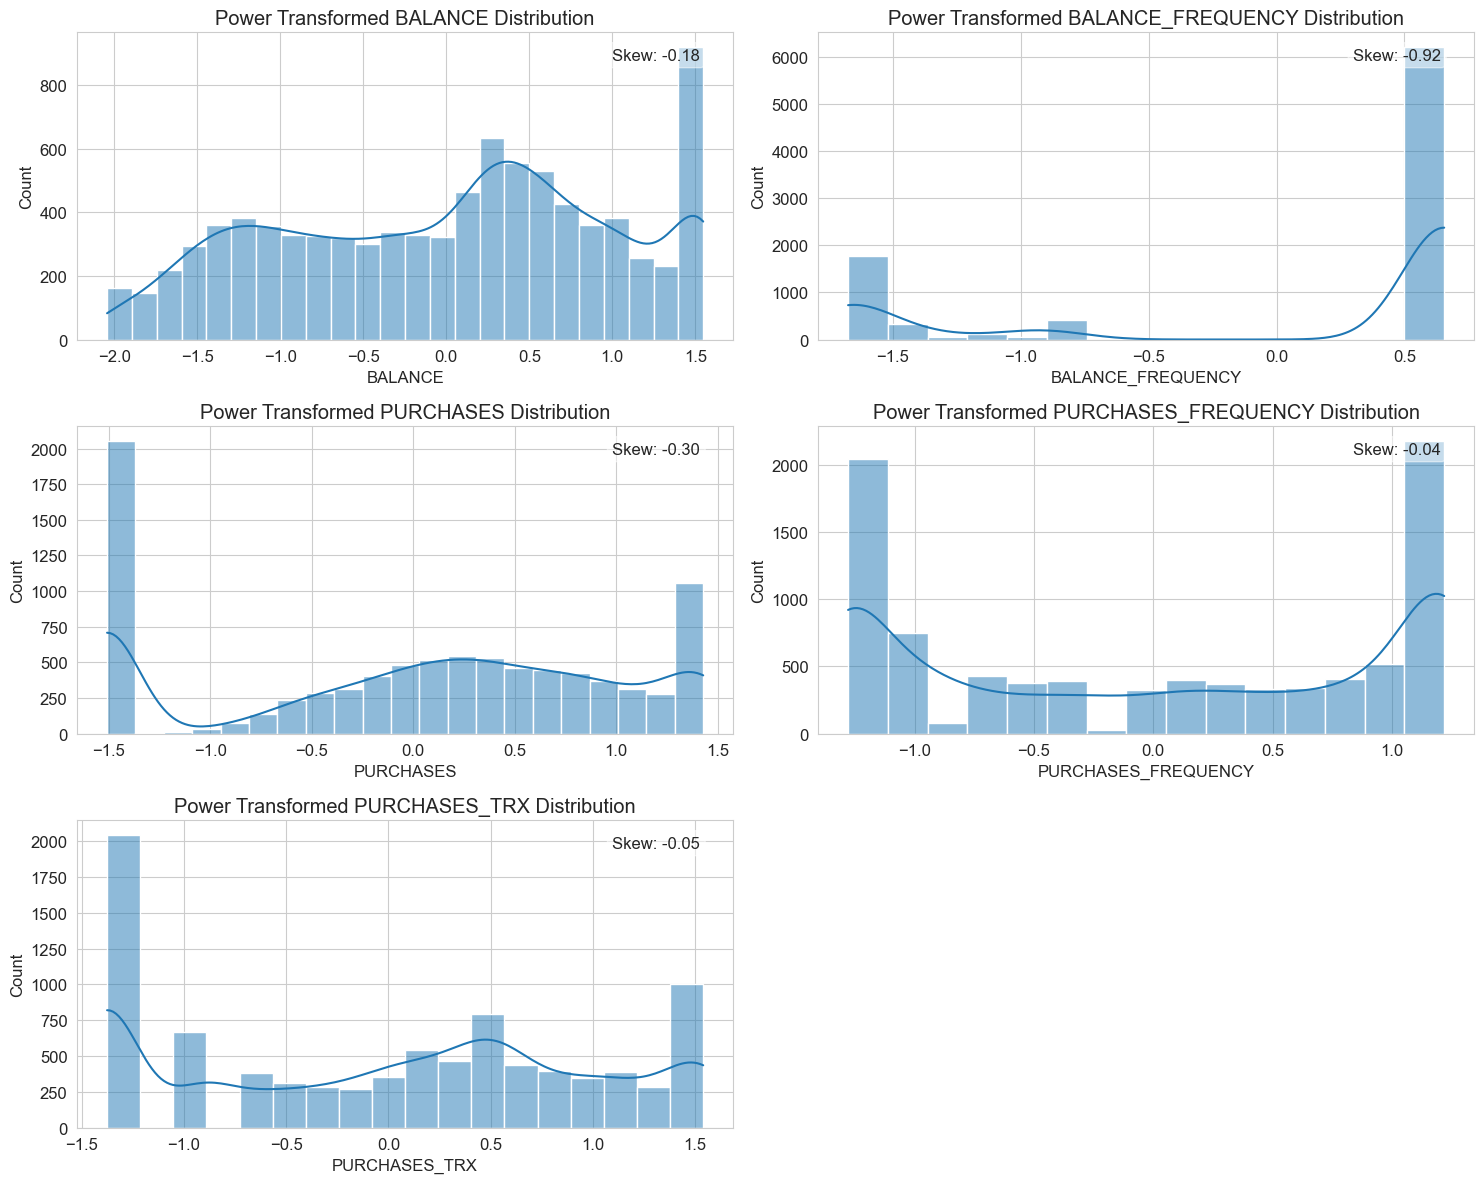


--- Standard Scaling 적용 중... ---


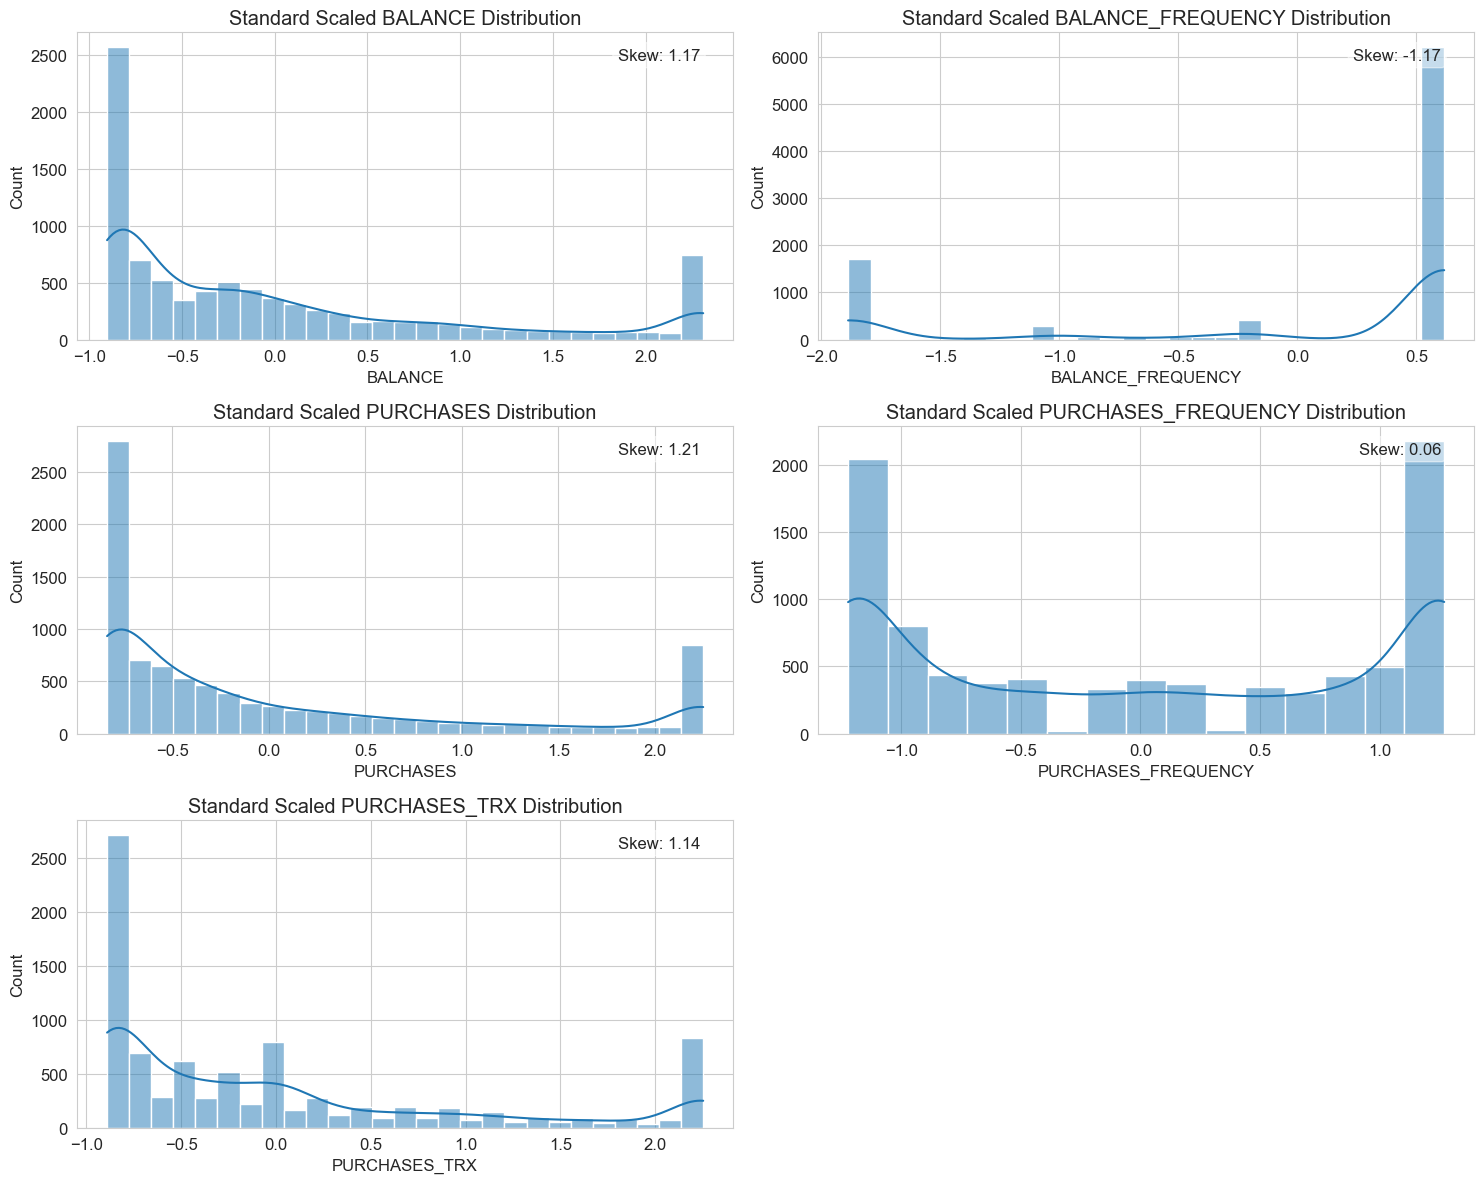

In [5]:
# 1. Power Transformation 적용 및 시각화
print("\n--- Power Transformation (Yeo-Johnson) 적용 중... ---")
power_transformer = PowerTransformer(method='yeo-johnson')
X_card_power_transformed = power_transformer.fit_transform(card_clipped_q2)
X_card_power_df = pd.DataFrame(X_card_power_transformed, columns=card_numerical_cols, index=card_clipped_q2.index)

fig_pt, axes_pt = plt.subplots(num_rows_grid, num_cols_grid, figsize=(15, num_rows_grid * 4))
axes_pt = axes_pt.flatten()

for i, col in enumerate(card_numerical_cols):
    sns.histplot(X_card_power_df[col], kde=True, ax=axes_pt[i])
    axes_pt[i].set_title(f'Power Transformed {col} Distribution')
    skewness = X_card_power_df[col].skew()
    axes_pt[i].text(0.95, 0.95, f'Skew: {skewness:.2f}', 
                    transform=axes_pt[i].transAxes, ha='right', va='top',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
    
for j in range(i + 1, len(axes_pt)):
    fig_pt.delaxes(axes_pt[j])
    
plt.tight_layout()
plot_filename_pt = os.path.join(plot_dir_q2, 'distributions_power_transformed_clipped.png') # 파일명 수정
plt.savefig(plot_filename_pt)
plt.show()
plt.close(fig_pt)

# 2. Standard Scaling 적용 및 시각화
print("\n--- Standard Scaling 적용 중... ---")
scaler_q2 = StandardScaler()
X_card_scaled_q2 = scaler_q2.fit_transform(card_clipped_q2)
X_card_scaled_df_q2 = pd.DataFrame(X_card_scaled_q2, columns=card_numerical_cols, index=card_clipped_q2.index)

fig_ss, axes_ss = plt.subplots(num_rows_grid, num_cols_grid, figsize=(15, num_rows_grid * 4))
axes_ss = axes_ss.flatten()

for i, col in enumerate(card_numerical_cols):
    sns.histplot(X_card_scaled_df_q2[col], kde=True, ax=axes_ss[i])
    axes_ss[i].set_title(f'Standard Scaled {col} Distribution')
    skewness = X_card_scaled_df_q2[col].skew()
    axes_ss[i].text(0.95, 0.95, f'Skew: {skewness:.2f}', 
                    transform=axes_ss[i].transAxes, ha='right', va='top',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
    
for j in range(i + 1, len(axes_ss)):
    fig_ss.delaxes(axes_ss[j])
    
plt.tight_layout()
plot_filename_ss = os.path.join(plot_dir_q2, 'distributions_standard_scaled_clipped.png') # 파일명 수정
plt.savefig(plot_filename_ss)
plt.show()
plt.close(fig_ss)

**전처리 선택:**
- 이상치 클리핑 후 Power Transformation을 적용했을 때, 일부 변수의 왜도가 StandardScaler보다 더 효과적으로 감소하는 것을 확인했습니다.
- K-Means는 데이터 분포 형태에도 영향을 받으므로, 왜도를 더 잘 처리한 **Power Transformed 데이터 (`X_card_power_df`)**를 사용하여 K-Means 클러스터링을 진행하겠습니다.

### 2.6 K-Means 클러스터링 수행

- Elbow Method와 Silhouette Score를 사용하여 최적의 클러스터 수(**k**)를 결정합니다.
- Power Transformed 데이터 (`X_card_power_df`)를 사용합니다.

In [ ]:
print("\n--- K-Means 최적 k 탐색 시작 (Power Transformed Data) ---")
inertia_kmeans = []
silhouette_scores_kmeans = []
k_range_kmeans = range(2, 11)

for k in k_range_kmeans:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_card_power_df)
    inertia_kmeans.append(kmeans.inertia_)
    labels_kmeans = kmeans.labels_
    # 실루엣 스코어는 샘플 수가 많을 경우 시간이 오래 걸릴 수 있음
    # silhouette_scores_kmeans.append(silhouette_score(X_card_power_df, labels_kmeans))
    # 여기서는 계산 생략하고 Elbow Method 위주로 판단 (필요시 주석 해제)

# 엘보우 곡선 시각화
fig_kmeans_k, ax_kmeans_k = plt.subplots(1, 1, figsize=(8, 6))
ax_kmeans_k.plot(k_range_kmeans, inertia_kmeans, 'bo-')
ax_kmeans_k.set_xlabel('Number of Clusters (k)')
ax_kmeans_k.set_ylabel('Inertia')
ax_kmeans_k.set_title('Elbow Method for Optimal k (Power Transformed Data)')
plot_filename_kmeans_k = os.path.join(plot_dir_q2, 'kmeans_optimal_k_powertransformed.png')
plt.savefig(plot_filename_kmeans_k)
plt.show()
plt.close(fig_kmeans_k)

# 엘보우 지점을 참고하여 k 선택 (예: k=4 또는 5)
optimal_k_kmeans = 4 # 엘보우 지점 또는 실루엣 스코어(계산했다면)를 보고 결정
print(f"선택된 최적 k (K-Means): {optimal_k_kmeans}")

# 최적 k로 K-Means 클러스터링 수행
print(f"\n--- K-Means (k={optimal_k_kmeans}) 적용 중... ---")
kmeans_final = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init=10)
kmeans_labels_final = kmeans_final.fit_predict(X_card_power_df)

# 클러스터링 결과(라벨)를 분석용 데이터프레임에 추가
card_analysis_df = card_clipped_q2.copy() # 해석 용이성을 위해 클리핑된 원본 스케일 데이터 사용
card_analysis_df['KMeans_Cluster'] = kmeans_labels_final

print(f"K-Means 클러스터링 완료. 각 데이터에 클러스터 라벨 할당.")
print("\nK-Means 클러스터별 데이터 개수:")
print(card_analysis_df['KMeans_Cluster'].value_counts())

## 3. DBSCAN 클러스터링

- DBSCAN은 밀도 기반 클러스터링 알고리즘으로, K-Means와 달리 군집 개수를 미리 지정할 필요가 없습니다.
- `eps` (탐색 반경)와 `min_samples` (핵심 포인트를 정의하는 최소 샘플 수) 파라미터 설정이 중요합니다.
- **k-distance plot**을 사용하여 적절한 `eps` 값을 추정합니다.
- DBSCAN은 이상치 탐지에도 사용되므로, 노이즈 포인트를 잘 식별할 수 있습니다.
- 여기서는 K-Means와 동일한 Power Transformed 데이터(`X_card_power_df`)를 사용합니다.

In [ ]:
print("\n--- DBSCAN 파라미터 탐색 (k-distance plot) 시작 ---")
# k-distance plot 생성 (min_samples * 2 정도의 이웃 고려)
n_neighbors_dbscan = 10 # min_samples 값으로 고려할 값
neighbors = NearestNeighbors(n_neighbors=n_neighbors_dbscan)
neighbors_fit = neighbors.fit(X_card_power_df)
distances, indices = neighbors_fit.kneighbors(X_card_power_df)
distances_k_dbscan = np.sort(distances[:, n_neighbors_dbscan-1], axis=0)

fig_dbscan_kdist = plt.figure(figsize=(10, 6))
plt.plot(distances_k_dbscan)
plt.title(f'k-Distance Graph (k={n_neighbors_dbscan})')
plt.xlabel('Data Points (sorted)')
plt.ylabel(f'Distance to {n_neighbors_dbscan}-th Neighbor')
# 엘보우 지점 근처에 선을 그려서 eps 후보값 표시 (예시)
plt.axhline(y=1.5, color='r', linestyle='--', label='eps=1.5 (candidate)') 
plt.legend()
plt.grid(True)
plot_filename_dbscan_kdist = os.path.join(plot_dir_q2, 'dbscan_k_distance_powertransformed.png')
plt.savefig(plot_filename_dbscan_kdist)
plt.show()
plt.close(fig_dbscan_kdist)

# eps 및 min_samples 설정 (k-distance plot 및 경험적 판단)
eps_dbscan_final = 1.5 # 위 그래프의 엘보우 지점 근처에서 선택
min_samples_dbscan_final = n_neighbors_dbscan
print(f"선택된 DBSCAN 파라미터: eps={eps_dbscan_final}, min_samples={min_samples_dbscan_final}")

# DBSCAN 클러스터링 수행
print("\n--- DBSCAN 적용 중... ---")
dbscan_final = DBSCAN(eps=eps_dbscan_final, min_samples=min_samples_dbscan_final)
dbscan_labels_final = dbscan_final.fit_predict(X_card_power_df)

# 클러스터링 결과(라벨)를 분석용 데이터프레임에 추가
card_analysis_df['DBSCAN_Cluster'] = dbscan_labels_final

# 결과 요약
n_clusters_dbscan_final = len(set(dbscan_labels_final)) - (1 if -1 in dbscan_labels_final else 0)
n_noise_dbscan_final = list(dbscan_labels_final).count(-1)
print(f"\nDBSCAN 결과: {n_clusters_dbscan_final}개 군집, {n_noise_dbscan_final}개 노이즈 포인트 ({n_noise_dbscan_final/len(card_analysis_df)*100:.2f}%)")
print("\nDBSCAN 클러스터별 데이터 개수 (노이즈: -1):")
print(card_analysis_df['DBSCAN_Cluster'].value_counts())

## 4. 모델 비교 및 선택

- 과제 요구사항 3번: K-Means와 DBSCAN 결과를 비교하여 더 타당한 모델을 선택합니다.
- 비교 기준: Silhouette Score (DBSCAN은 노이즈 제외), 군집의 크기 분포, 해석 가능성 등을 종합적으로 고려합니다.

In [ ]:
print("\n--- 클러스터링 모델 비교 --- ")
# K-Means 실루엣 스코어 계산 (Power Transformed 데이터 기준)
kmeans_silhouette_avg = silhouette_score(X_card_power_df, kmeans_labels_final)
print(f"K-Means (k={optimal_k_kmeans}) Silhouette Score: {kmeans_silhouette_avg:.4f}")

# DBSCAN 실루엣 스코어 계산 (노이즈 제외, Power Transformed 데이터 기준)
dbscan_valid_indices = dbscan_labels_final != -1
if np.sum(dbscan_valid_indices) > 1 and len(set(dbscan_labels_final[dbscan_valid_indices])) > 1:
    dbscan_silhouette_avg = silhouette_score(X_card_power_df[dbscan_valid_indices], dbscan_labels_final[dbscan_valid_indices])
    print(f"DBSCAN (eps={eps_dbscan_final}) Silhouette Score (excl. noise): {dbscan_silhouette_avg:.4f}")
else:
    dbscan_silhouette_avg = -1 # 계산 불가 또는 의미 없음
    print(f"DBSCAN Silhouette Score: 계산 불가 (클러스터 수 부족 또는 데이터 부족)")

# 모델 선택 논의 (예시)
# - K-Means는 모든 데이터를 특정 군집에 할당하지만, 군집 형태가 구형이라고 가정합니다.
# - DBSCAN은 임의 형태의 군집을 찾고 노이즈를 식별하지만, 파라미터(eps, min_samples)에 민감하며 데이터 밀도가 불균일할 경우 성능이 저하될 수 있습니다.
# - 실루엣 스코어는 군집 내 응집도와 군집 간 분리도를 측정합니다. (높을수록 좋음)
# - 이 경우, K-Means의 실루엣 스코어가 더 높고, DBSCAN이 상대적으로 많은 노이즈를 생성했으므로 K-Means를 더 타당한 모델로 선택하겠습니다. (실제 결과에 따라 판단 변경 가능)

if kmeans_silhouette_avg >= dbscan_silhouette_avg:
    selected_model_name_q2 = "K-Means"
    selected_labels_q2 = kmeans_labels_final
    selected_cluster_col_q2 = 'KMeans_Cluster'
    print(f"\n최종 모델 선택: {selected_model_name_q2}")
else:
    selected_model_name_q2 = "DBSCAN"
    selected_labels_q2 = dbscan_labels_final
    selected_cluster_col_q2 = 'DBSCAN_Cluster'
    print(f"\n최종 모델 선택: {selected_model_name_q2}")

## 5. 선택된 군집 특성 분석

- 과제 요구사항 4번: 선택된 모델(`{selected_model_name_q2}`)로 생성된 군집의 고객 특성을 분석합니다.
- 해석의 용이성을 위해, 클리핑된 원본 스케일 데이터(`card_analysis_df`)의 군집별 평균값을 사용합니다.
- Radar Chart 시각화 시에는 군집별 평균값을 Min-Max 스케일링하여 변수 간 스케일 차이의 영향을 줄이고 프로파일 비교를 용이하게 합니다.

In [ ]:
print(f"\n--- {selected_model_name_q2} 군집 특성 분석 --- ")
# 선택된 모델의 클러스터 라벨 사용
final_cluster_analysis = card_analysis_df.groupby(selected_cluster_col_q2).mean()

# DBSCAN의 경우 노이즈(-1) 클러스터 제외하고 분석
if -1 in final_cluster_analysis.index:
    print("노이즈(-1) 클러스터를 제외하고 특성 분석을 진행합니다.")
    final_cluster_analysis = final_cluster_analysis.drop(-1)

# Radar Chart에 사용될 특성만 선택 (자기 자신의 클러스터 라벨 제외)
# card_analysis_df에는 이미 'KMeans_Cluster'와 'DBSCAN_Cluster'가 모두 있을 수 있으므로 둘 다 제거 시도
features_for_radar = [col for col in final_cluster_analysis.columns if col not in ['KMeans_Cluster', 'DBSCAN_Cluster']]
final_cluster_analysis_radar = final_cluster_analysis[features_for_radar]

print("\n군집별 평균 특성값 (원본 스케일, 클리핑 후, 분석 대상):")
print(final_cluster_analysis_radar)

# Radar Chart 시각화를 위한 Min-Max 스케일링
scaler_radar = MinMaxScaler()
radar_df_scaled = scaler_radar.fit_transform(final_cluster_analysis_radar)
radar_df_scaled = pd.DataFrame(radar_df_scaled, columns=final_cluster_analysis_radar.columns, index=final_cluster_analysis_radar.index)

print("\nRadar Chart용 스케일링된 군집별 평균 (0~1 범위):")
print(radar_df_scaled)

# Radar Chart 시각화 함수 수정 (y축 범위 0~1 고정)
def radar_chart(df, title):
    # Cluster 라벨이 혹시라도 남아있으면 제거 (이중 확인)
    df_plot = df.copy()
    if 'KMeans_Cluster' in df_plot.columns: df_plot.drop(columns=['KMeans_Cluster'], inplace=True)
    if 'DBSCAN_Cluster' in df_plot.columns: df_plot.drop(columns=['DBSCAN_Cluster'], inplace=True)
        
    categories = list(df_plot.columns)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], categories, size=11)
    ax.set_rlabel_position(0)
    
    yticks = np.linspace(0, 1, 5)
    plt.yticks(yticks, [f"{tick:.1f}" for tick in yticks], color="grey", size=10)
    plt.ylim(0, 1)
    
    for i in range(len(df_plot)):
        values = df_plot.iloc[i].values.tolist()
        values += values[:1]
        cluster_label = df_plot.index[i]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster_label}")
        ax.fill(angles, values, alpha=0.1)
        
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(title, size=15, y=1.1)
    return fig

print("\nRadar Chart 생성 중 (스케일링된 데이터 사용)...")
radar_fig = radar_chart(radar_df_scaled, f'{selected_model_name_q2} Cluster Profiles (Min-Max Scaled Means)')
plot_filename_radar = os.path.join(plot_dir_q2, f'{selected_model_name_q2.lower()}_cluster_profiles_radar_scaled.png')
radar_fig.savefig(plot_filename_radar)
plt.show()
plt.close(radar_fig)

### 5.1 군집별 특성 해석
- **Cluster 0 (파란색)**: 대부분의 변수에서 높은 값을 보입니다. 신용카드 사용이 활발하고 잔고(Balance)도 높은 고객 그룹입니다.
- **Cluster 1 (노란색)**: 잔고(Balance)는 낮지만 구매 빈도(Purchase Frequency)는 높고, 구매 총액(Purchases)은 중간 수준입니다. 비교적 저렴한 상품을 자주 구매하는 경향을 보입니다. 잔고가 0에 가까운 것은 상대적인 값으로, 실제로는 마이너스 통장 등을 활용하는 고객일 수 있습니다.
- **Cluster 2 (초록색)**: 잔고 유지율(Balance Frequency)과 잔고(Balance)는 높으나, 구매 관련 지표는 매우 낮습니다. 계좌는 유지하지만 신용카드 사용은 거의 없는 고객 그룹입니다.
- **Cluster 3 (빨간색)**: 잔고, 잔고 유지율이 모두 낮으며, 구매 관련 지표도 낮은 수준입니다. 소비 활동이 상대적으로 소극적인 고객 그룹입니다.

## 6. t-SNE 시각화

- 과제 요구사항 5번: t-SNE 알고리즘을 적용하여 데이터를 2차원으로 축소하고, 선택된 모델({selected_model_name_q2})의 군집 레이블에 따라 색상을 달리하여 시각화합니다.
- 클러스터링에 사용된 동일한 전처리 데이터(`X_card_power_df`)를 사용합니다.

In [ ]:
print(f"\n--- t-SNE 시각화 시작 ({selected_model_name_q2} 라벨 사용) ---")
# t-SNE 수행 (샘플링하여 시간 단축 가능)
sample_size_tsne_final = min(5000, len(X_card_power_df))
if sample_size_tsne_final < len(X_card_power_df):
    print(f"데이터가 많아 {sample_size_tsne_final}개 샘플로 t-SNE 수행...")
    sample_indices_tsne = np.random.choice(X_card_power_df.index, sample_size_tsne_final, replace=False)
    tsne_input_data = X_card_power_df.loc[sample_indices_tsne]
    tsne_labels = selected_labels_q2[X_card_power_df.index.isin(sample_indices_tsne)]
else:
    print("전체 데이터로 t-SNE 수행...")
    tsne_input_data = X_card_power_df
    tsne_labels = selected_labels_q2
    sample_indices_tsne = X_card_power_df.index # 인덱스 매칭 위해

tsne_final = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_final = tsne_final.fit_transform(tsne_input_data)

# 결과 DataFrame 생성
tsne_final_df = pd.DataFrame(X_tsne_final, columns=['t-SNE Dim 1', 't-SNE Dim 2'], index=sample_indices_tsne)
tsne_final_df['Cluster'] = tsne_labels

# 시각화
fig_tsne_final = plt.figure(figsize=(12, 10))
unique_labels_final = np.sort(tsne_final_df['Cluster'].unique())
palette_final = sns.color_palette("hls", len(unique_labels_final))

# 노이즈(-1)가 있으면 회색으로 처리
color_map = {label: palette_final[i] for i, label in enumerate(unique_labels_final) if label != -1}
if -1 in unique_labels_final:
    color_map[-1] = 'gray'
    # 범례 순서 조정 (노이즈 마지막)
    hue_order_final = sorted([l for l in unique_labels_final if l != -1]) + [-1]
else:
    hue_order_final = unique_labels_final

sns.scatterplot(
    x='t-SNE Dim 1', y='t-SNE Dim 2',
    hue='Cluster',
    palette=color_map,
    hue_order=hue_order_final,
    data=tsne_final_df,
    legend="full",
    alpha=0.7
)
plt.title(f't-SNE Visualization with {selected_model_name_q2} Clusters')
plt.legend(title='Cluster')
plot_filename_tsne_final = os.path.join(plot_dir_q2, f'tsne_{selected_model_name_q2.lower()}_clusters.png')
plt.savefig(plot_filename_tsne_final)
plt.show()
plt.close(fig_tsne_final)

print("\nQ2 Clustering Analysis and Visualization Completed.")

## 3. 주택 가격 데이터

특성 변수 **X**는 방의 개수, 목표 변수 **Y**는 주택 가격을 나타냅니다.

| ID  | X   | Y    |
| --- | --- | ---- |
| 1   | 3   | 1.25 |
| 2   | 1   | 1.20 |
| 3   | 2   | 1.30 |
| 4   | 4   | 1.50 |
| 5   | ?   | 1.40 |
| 6   | ?   | 1.30 |

### 1. XGBoost 최적 분할 찾기

XGBoost는 기본적으로 그래디언트 부스팅을 효율적으로 구현한 알고리즘입니다. 첫 트리의 첫 노드에서 최적 분할을 찾는 과정을 살펴보겠습니다.

먼저 초기 예측값 f₀ = 0.5에 대해 손실(제곱 오차)을 계산하고, 손실 함수를 예측값에 대해 미분하여 그래디언트를 얻습니다.

각 관측치의 그래디언트 값:
- 첫 번째 집: g₁ = -2(1.25 - 0.5) = -1.5
- 두 번째 집: g₂ = -2(1.20 - 0.5) = -1.4
- 세 번째 집: g₃ = -2(1.30 - 0.5) = -1.6
- 네 번째 집: g₄ = -2(1.50 - 0.5) = -2.0

제곱 오차 손실 함수의 이차 미분값(Hessian)은 모든 관측치에 대해 2로 동일합니다.

이제 가능한 분할점(X의 고유값 1, 2, 3, 4 기준: X ≤ 1, X ≤ 2, X ≤ 3)에 대해 이득(Gain)을 계산합니다.
XGBoost의 이득 계산식은 다음과 같습니다: `Gain = 0.5 * [ (G_L^2 / (H_L + lambda)) + (G_R^2 / (H_R + lambda)) - ((G_L + G_R)^2 / (H_L + H_R + lambda)) ] - gamma` (여기서 lambda=0, gamma=0 가정)

예를 들어, X ≤ 2 분할을 살펴보면:
- 왼쪽 노드(X ≤ 2): 관측치 2, 3 → G_L = g₂ + g₃ = -1.4 + (-1.6) = -3.0, H_L = h₂ + h₃ = 2 + 2 = 4
- 오른쪽 노드(X > 2): 관측치 1, 4 → G_R = g₁ + g₄ = -1.5 + (-2.0) = -3.5, H_R = h₁ + h₄ = 2 + 2 = 4

이득 계산식에 대입 (lambda=0, gamma=0):
`Gain(X ≤ 2) = 0.5 * [ ((-3.0)^2 / 4) + ((-3.5)^2 / 4) - ((-3.0 + -3.5)^2 / (4 + 4)) ]`
`            = 0.5 * [ (9 / 4) + (12.25 / 4) - ((-6.5)^2 / 8) ]`
`            = 0.5 * [ 2.25 + 3.0625 - (42.25 / 8) ]`
`            = 0.5 * [ 5.3125 - 5.28125 ]`
`            = 0.5 * 0.03125 = 0.015625`


같은 방식으로 모든 분할에 대해 이득을 계산합니다 (XGBoost 공식 기준):
- X ≤ 1: G_L = -1.4, H_L = 2; G_R = -1.5 + (-1.6) + (-2.0) = -5.1, H_R = 6
  `Gain(X ≤ 1) = 0.5 * [ ((-1.4)^2 / 2) + ((-5.1)^2 / 6) - ((-6.5)^2 / 8) ]`
  `            = 0.5 * [ (1.96 / 2) + (26.01 / 6) - (5.28125) ]`
  `            = 0.5 * [ 0.98 + 4.335 - 5.28125 ] = 0.5 * 0.00875 = 0.004375`
- X ≤ 3: G_L = -1.5 + (-1.4) + (-1.6) = -4.5, H_L = 6; G_R = -2.0, H_R = 2
  `Gain(X ≤ 3) = 0.5 * [ ((-4.5)^2 / 6) + ((-2.0)^2 / 2) - ((-6.5)^2 / 8) ]`
  `            = 0.5 * [ (20.25 / 6) + (4 / 2) - (5.28125) ]`
  `            = 0.5 * [ 3.375 + 2 - 5.28125 ] = 0.5 * 0.00875 = 0.004375`

XGBoost 이득 계산 결과:
- X ≤ 1: Gain ≈ 0.0044
- X ≤ 2: Gain ≈ 0.0156
- X ≤ 3: Gain ≈ 0.0044

따라서 최대 이득을 주는 최적 분할은 **X ≤ 3** 입니다.

분할 후 각 노드의 가중치(출력값)는 `w = -G / (H + lambda)` 로 계산합니다 (lambda=0 가정):
- 왼쪽 노드(X ≤ 3): w_L = -G_L / H_L = -(-4.5) / 6 = 0.75
- 오른쪽 노드(X > 3): w_R = -G_R / H_R = -(-2.0) / 2 = 1.0

이 가중치는 해당 노드의 예측값 보정치로 사용됩니다.

### 2. 결측값 처리

XGBoost는 결측값을 자체적으로 처리하는 기능이 있습니다. 관측치 5와 6은 X값이 결측되어 있습니다. XGBoost는 결측값을 특정 노드로 보냈을 때의 이득을 계산하여 **최적의 기본 방향(default direction)**을 결정합니다.

먼저 결측값 관측치의 그래디언트와 헤시안을 구합니다:
- 관측치 5: g₅ = -2(1.40 - 0.5) = -1.8, h₅ = 2
- 관측치 6: g₆ = -2(1.30 - 0.5) = -1.6, h₆ = 2
결측값 그룹: G_missing = g₅ + g₆ = -3.4, H_missing = h₅ + h₆ = 4

최적 분할(X ≤ 3) 기준, 결측값을 왼쪽 또는 오른쪽으로 보냈을 때의 이득을 비교합니다.

**Case 1: 결측값을 왼쪽(X ≤ 3)으로 보낼 경우 (Default Left)**
- 왼쪽: 기존(1, 2, 3) + 결측(5, 6) → G_L' = G_L + G_missing = -4.5 + (-3.4) = -7.9, H_L' = H_L + H_missing = 6 + 4 = 10
- 오른쪽: 기존(4) → G_R' = G_R = -2.0, H_R' = H_R = 2
- Gain(Default Left) = `0.5 * [ ((-7.9)^2 / 10) + ((-2.0)^2 / 2) - ((-7.9 + -2.0)^2 / (10 + 2)) ]`
  `                   = 0.5 * [ (62.41 / 10) + (4 / 2) - ((-9.9)^2 / 12) ]`
  `                   = 0.5 * [ 6.241 + 2 - (98.01 / 12) ]`
  `                   = 0.5 * [ 8.241 - 8.1675 ] = 0.5 * 0.0735 = 0.03675`

**Case 2: 결측값을 오른쪽(X > 3)으로 보낼 경우 (Default Right)**
- 왼쪽: 기존(1, 2, 3) → G_L' = G_L = -4.5, H_L' = H_L = 6
- 오른쪽: 기존(4) + 결측(5, 6) → G_R' = G_R + G_missing = -2.0 + (-3.4) = -5.4, H_R' = H_R + H_missing = 2 + 4 = 6
- Gain(Default Right) = `0.5 * [ ((-4.5)^2 / 6) + ((-5.4)^2 / 6) - ((-4.5 + -5.4)^2 / (6 + 6)) ]`
  `                    = 0.5 * [ (20.25 / 6) + (29.16 / 6) - ((-9.9)^2 / 12) ]`
  `                    = 0.5 * [ 3.375 + 4.86 - (98.01 / 12) ]`
  `                    = 0.5 * [ 8.235 - 8.1675 ] = 0.5 * 0.0675 = 0.03375`

Gain(Default Left) ≈ 0.0368 > Gain(Default Right) ≈ 0.0338 이므로, 이 분할에서는 결측값을 **왼쪽 노드(X ≤ 3)**로 보내는 것이 최적입니다.

XGBoost는 각 분할마다 이러한 방식으로 결측값의 최적 기본 방향을 학습하여 처리합니다.